# Generate a stone like geometry

Idea here is to generate a set of random points, pick some in the middle that are inside an ellipsoid and compute the surface of the Voronoi tesselation of the points inside with the points outside.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
param = {
    'dims': (50, 50, 50),
    'numCells': 1000,
    'maxCellSize': 1000,
}
fudge = 0.1
po = []
for i in range(param['numCells']):
    x = fudge + (np.random.rand(1)-.5) * (param['dims'][0]-1.-fudge)
    y = fudge + (np.random.rand(1)-.5) * (param['dims'][1]-1.-fudge)
    z = fudge + (np.random.rand(1)-.5) * (param['dims'][2]-1.-fudge)
    po.append([x.item(),y.item(),z.item()])

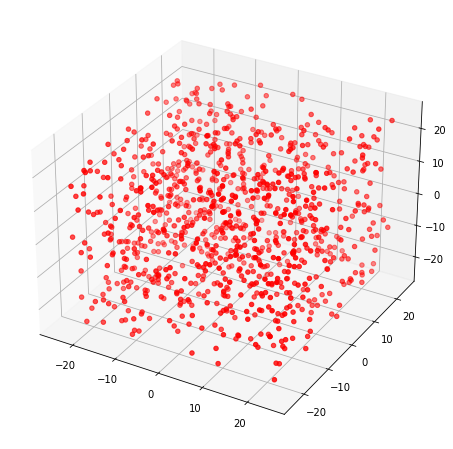

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([item[0] for item in po],[item[1] for item in po],[item[2] for item in po],c='r',marker='o')

Just use the square of a random 3x3 matrix and scale it appropriately. From there we can use a quadratic form to test if a point is inside or outside.

In [4]:
tbt = (np.random.rand(9)).reshape((3,3))
# squaring a random matrix gives us a positive definite matrix
tbt = tbt @ tbt.T
tbt = tbt + 3*np.eye(3)
# but we can do it manually as well
#tbt[0,1] = tbt[1,0] 
#tbt[0,2] = tbt[2,0]
#tbt[1,2] = tbt[2,1]

#[evals, evects] = np.linalg.eig(tbt)
# using svd we expect the eigenvalues to be positive
[u, D, vh] = np.linalg.svd(tbt)
#print(D)
# substituting our own eigenvalues back in
D = (1/400,1/250,1/150)
print(D)

# This would be our new (positive definite) matrix with random rotation, ready for our quadratic form

A = np.dot(u * D, vh)

# So why is this wrong?
print(np.linalg.eig(A))


(0.0025, 0.004, 0.006666666666666667)
(array([0.0025    , 0.004     , 0.00666667]), array([[-0.37687966, -0.92563057,  0.03420195],
       [-0.6818759 ,  0.25226302, -0.68659204],
       [-0.62690269,  0.28208406,  0.72623798]]))


In [5]:
def distance(v, A):
    v = v.reshape((3,1))
    #print(np.transpose(v) @ A @ v, v)
    b = (np.transpose(v) @ A) @ v
    if (b < 0):
        print("negative", b)
        b = abs(b)
    return np.sqrt(b)

# return 1 or zero if the point is inside the ellipsoid
def classify(po, A):
    classes = []
    for i in range(len(po)):
        if distance(np.asarray(po[i]),A) < 1:
            classes.append(1)
        else:
            classes.append(0)
    return classes
cls = classify(po, A)
#cls

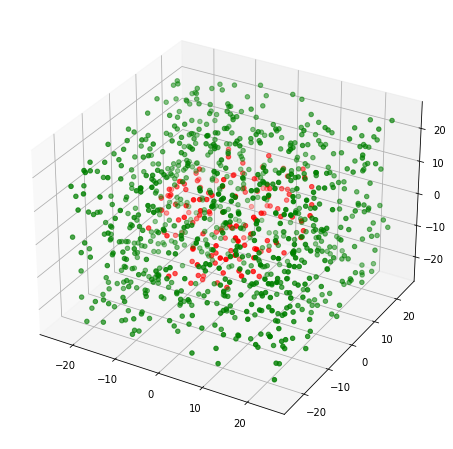

In [6]:
#%matplotlib inline
#%matplotlib qt
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
poIn = [po[i] for i in range(len(po)) if cls[i] == 1]
poOut = [po[i] for i in range(len(po)) if cls[i] == 0]
ax.scatter([item[0] for item in poIn],[item[1] for item in poIn],[item[2] for item in poIn],c='r',marker='o')
ax.scatter([item[0] for item in poOut],[item[1] for item in poOut],[item[2] for item in poOut],c='g',marker='o')

In [7]:
# We distribute cell cores evenly in the volume but we will not get too close to the border (unit is pixel).

def generateCellPointsOfInterest(param):
    fudge = 5
    x_ = np.linspace(0., param['dims'][0]-1., 64)
    y_ = np.linspace(0., param['dims'][1]-1., 64)
    z_ = np.linspace(0., param['dims'][2]-1., 32)
    xg, yg, zg = np.meshgrid(x_, y_, z_, indexing='ij')

    numCells = param['numCells']
    # all cells are space filling, place them randomly, compute the influence region and move to center
    po = []
    for i in range(numCells):
        x = fudge + np.random.rand(1) * (param['dims'][0]-1-fudge)
        y = fudge + np.random.rand(1) * (param['dims'][1]-1.-fudge)
        z = fudge + np.random.rand(1) * (param['dims'][2]-1.-fudge)
        po.append([x.item(),y.item(),z.item()])
    return [xg, yg, zg, po]

def influence(xg,yg,zg,po,param):
    # now compute the influence region
    influence = []
    for i in range(param['numCells']):
        influence.append([])
    xgg = xg.reshape(np.prod(xg.shape), 1)
    ygg = yg.reshape(np.prod(yg.shape), 1)
    zgg = zg.reshape(np.prod(zg.shape), 1)
    # for each voxel coordinate in the volume
    for idx in range(np.prod(xg.shape)):
        x = xgg[idx].item()
        y = ygg[idx].item()
        z = zgg[idx].item()
        minidx = 0
        # this corresponds to the maximum cell radius
        minDist = param['maxCellSize']
        for i in range(param['numCells']):
            x_ = po[i][0]
            y_ = po[i][1]
            z_ = po[i][2]
            d = (x-x_)**2+(y-y_)**2+(z-z_)**2
            if d < minDist:
                minDist = d
                minidx = i
        influence[minidx].append([x, y, z])
    return influence

def centroids(influence):
    cent = []
    for i in range(len(influence)):
        c = [0, 0, 0]
        c[0] = np.mean(np.array(influence[i])[:, 0])
        c[1] = np.mean(np.array(influence[i])[:, 1])
        c[2] = np.mean(np.array(influence[i])[:, 2])
        cent.append(c)
    return cent

# shape is a tupel of dimensions, size is a tupel of voxel sizes
def render2Volume(po, classes, size, shape):
    x_ = np.linspace(0., size[0]*(shape[0]-1), shape[0])
    y_ = np.linspace(0., size[1]*(shape[1]-1), shape[1])
    z_ = np.linspace(0., size[2]*(shape[2]-1), shape[2])
    xg, yg, zg = np.meshgrid(x_, y_, z_, indexing='ij')
    infl = influence(xg,yg,zg,po,param)
    r = np.zeros(shape, dtype=np.int16)
    for i in range(len(infl)):
        for j in range(len(infl[i])):
            x, y, z = infl[i][j]
            r[math.floor(x),math.floor(y),math.floor(z)] = classes[i]+1
    return r

In [8]:
import math
# shift the centroids
po2 = []
for i in range(len(po)):
    po2.append(po[i]+(np.asarray(param['dims'])/2))
r = render2Volume(po2, cls, [1, 1, 1], [param['dims'][0],param['dims'][1],param['dims'][2]])

# resample to even larger resolution
#from scipy.ndimage import zoom
#r2 = zoom(r.astype('int16'), (2, 2, 2), order=0, mode='nearest')

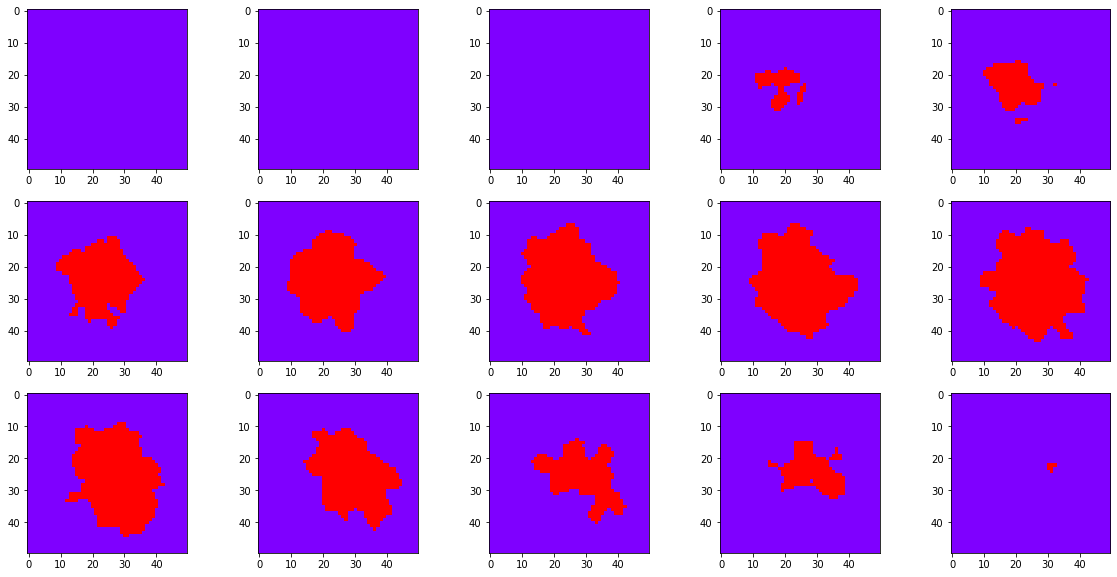

In [9]:
#%matplotlib inline
figure = plt.figure(figsize=(20,10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(r[:,:,i*math.floor(r.shape[2]/15)], cmap='rainbow')

In [10]:
# create a pointset from the voxel at the border of the volume (for marching cubes)
po3 = []
for i in range(np.prod(r.shape)):
    x, y, z = np.unravel_index(i, r.shape)
    if x > 0 and y > 0 and z > 0 and x < r.shape[0]-1 and y < r.shape[1]-1 and z < r.shape[2]-1:
        # at least one neighbor at the border?
        if r[x,y,z] == 2:
            sumN = (r[x-1,y,z] == 1) + (r[x+1,y,z] == 1) + (r[x,y-1,z] == 1) + (r[x,y+1,z] == 1) + (r[x,y,z-1] == 1) + (r[x,y,z+1] == 1)
            if sumN > 0 and sumN < 6:
                po3.append([x,y,z])

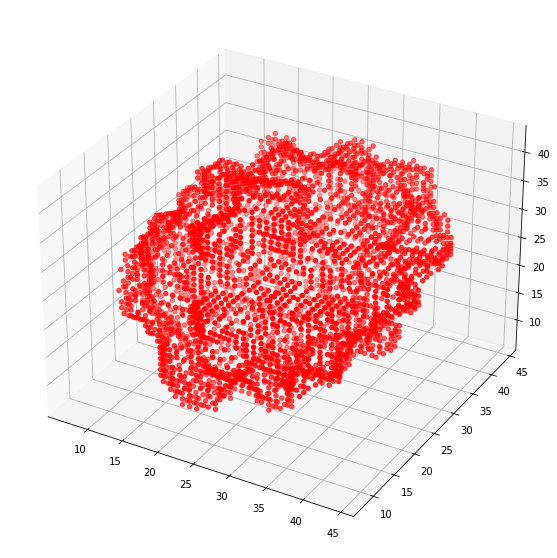

In [11]:
#%matplotlib qt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([item[0] for item in po3],[item[1] for item in po3],[item[2] for item in po3],c='r',marker='o')

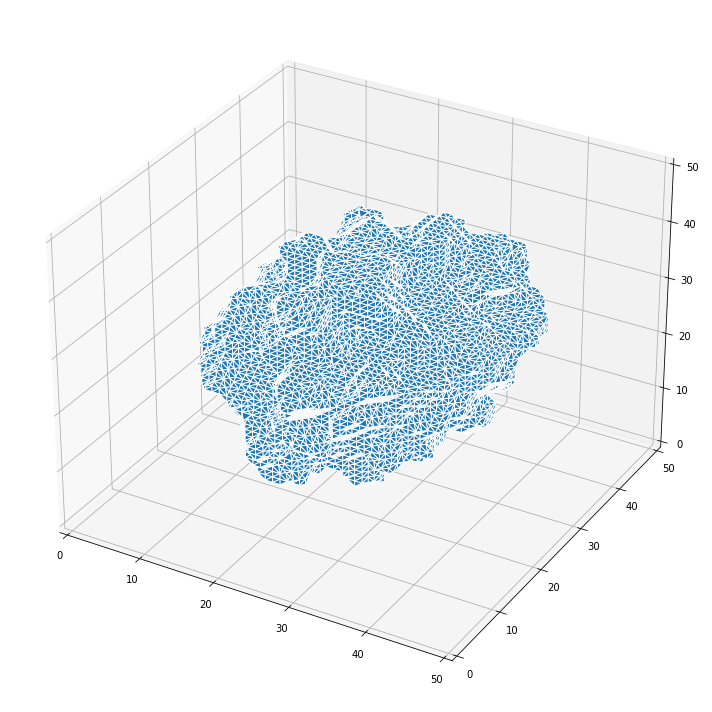

In [12]:
# generate surface
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
verts, faces, normals, values = measure.marching_cubes(r, 1.5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('w')
ax.add_collection3d(mesh)

ax.set_xlim(0, r.shape[0])
ax.set_ylim(0, r.shape[1])
ax.set_zlim(0, r.shape[2]) 
plt.tight_layout()
plt.show()

In [13]:
def normal(p1, p2, p3):
    v1 = np.asarray(p2) - np.asarray(p1)
    v2 = np.asarray(p3) - np.asarray(p1)
    return np.cross(v1, v2)

# export all the triangles to an stl file
def saveAsSTL(fname, vertices, triangles):
    with open(fname, 'w') as f:
        f.write('solid stone\n')
        for i in range(len(triangles)):
            n = normal(vertices[triangles[i][2]], vertices[triangles[i][1]], vertices[triangles[i][0]])
            f.write('facet normal %f %f %f\n' % (n[0], n[1], n[2]))
            f.write('outer loop\n')
            for j in range(3):
                f.write('vertex %f %f %f\n' % (vertices[triangles[i][j]][2], vertices[triangles[i][j]][1], vertices[triangles[i][j]][0]))
            f.write('endloop\n')
            f.write('endfacet\n')
        f.write('endsolid\n')
saveAsSTL('/tmp/stone.stl', verts, faces)